In [ ]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:            25G        9.2G         10G        1.2M        5.7G         18G
Swap:            0B          0B          0B


# Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mp_patches
import pandas as pd

## Get Files

In [ ]:
url = 'https://drive.google.com/file/d/1CGJjRTumHvTi2mFbxRNIp-MQofhQ9pKy/view?usp=sharing'
batch_name = '041021_full_tests'

In [ ]:
!ls "{batch_name}.tar.xz" 2>/dev/null || (python -m pip install gdown --upgrade > /dev/null && gdown --fuzzy "{url}")

041021_full_tests.tar.xz


In [ ]:
!ls "{batch_name}/" 2>/dev/null 1>/dev/null || tar xvf "{batch_name}.tar.xz"

In [ ]:
cache_processed_data = True 

# Run List

In [ ]:
root = batch_name
run_list = '.run_list.temp'
!ls {root} -1 | tee {run_list}

line_1
triangle_1
triangle_2


In [ ]:
runs = [a.strip() for a in open(run_list) if a != '']

In [ ]:
fs = 1e6
dt = 1.0 / fs

In [ ]:
import numpy as np

In [ ]:
L = 9.025
W = 2.96
D = -3.5

h_locs = np.array((
    (291,   0, -250),
    (620,   0, -100),
    (280, 296,  -15),
    (607, 296, -150),
)).astype(np.float64)
h_locs /= 100

ground_truth = np.array((
    (461.52, 260.53),
    (  0.00, 148.00),
    (458.52,  38.55),
)).astype(np.float64)
ground_truth /= 100
ground_truth = np.vstack((ground_truth, ground_truth[0:1, ...]))

# Helpers

## Pico Loader

In [ ]:
import numpy as np

from scipy.signal import butter, lfilter, filtfilt, hilbert
class BP:
    def __init__(self, fs=1e6, low=30e3, high=50e3, order=5, preserve_phase=False):
        nyq = 0.5 * fs
        self.coeffs = butter(order, [low / nyq, high / nyq], btype='band')
        self.apply = filtfilt if preserve_phase else lfilter

    def __call__(self, data):
        return self.apply(*self.coeffs, data, axis=0)

class MA:
    def __init__(self, fs=1e6, dt=1e-3, apply_abs=True):
        self.n = int(fs * dt)
        self.kernel = np.ones((self.n,), dtype=np.int32) / self.n
        self.apply_abs = apply_abs

    def __call__(self, data):
        if self.apply_abs:
            if len(data.shape) == 1:
                return np.convolve(np.abs(data), self.kernel, mode='same')

            out = np.empty_like(data)
            for i in range(data.shape[1]):
                out[:, i] = np.convolve(np.abs(data[:, i]), self.kernel, mode='same')
            return out
        else:
            if len(data.shape) == 1:
                return np.convolve(data, self.kernel, mode='same')

            out = np.empty_like(data)
            for i in range(data.shape[1]):
                out[:, i] = np.convolve(data[:, i], self.kernel, mode='same')
            return out
            

class Hilbert:
    def __init__(self, fs=1e6):
        pass

    def __call__(self, data):
        return np.abs(hilbert(data))

    
import struct
class PicoDataLoader:
    bufsize = 100000
    time_len = struct.calcsize('<d')
    time_unpack = struct.Struct('<d').unpack_from
    
    def __init__(self, filename, # filename: Union[str, path_like, File object]
                 bp_args={'fs': fs, 'low': 35e3, 'high':45e3},
                 ma_args={'fs': fs, 'dt': 6e-5},
                 hil_args=None,  # {'fs': fs,},
                 preserve_chA=False,
                 num_channels=6
                ):  
        self.filename = filename
        self.file = None
        self.preserve_chA = preserve_chA
        self.num_channels = num_channels

        self.transformers = []
        if bp_args is not None:
            self.transformers.append(BP(**bp_args))
        if ma_args is not None:
            self.transformers.append(MA(**ma_args))
        if hil_args is not None:
            self.transformers.append(Hilbert(**hil_args))
    
    def open(self):
        if self.file is not None:
            self.close()
        
        # For compatibility with tarfiles
        # See: https://github.com/numpy/numpy/issues/7989#issuecomment-340921579
        import io
        if isinstance(self.filename, io.BufferedReader):
          array_file = io.BytesIO()
          array_file.write(self.filename.read())
          array_file.seek(0)
          self.file = array_file
        else:
          self.file = open(self.filename, 'rb')
    
    def get(self):
        if self.file is None:
            raise Exception("Use ```open``` and ```close```")
        try:
            t = self.time_unpack(self.file.read(self.time_len))[0]
            arr = np.load(self.file)[:, :self.num_channels]
            dtype = arr.dtype
            
            if self.preserve_chA:
                chA = arr[:, 0].copy()
            
            for tran in self.transformers:
                arr = tran(arr)
            
            arr = arr.astype(dtype)
            if self.preserve_chA:
                arr[:, 0] = chA
            
            return t, arr
        except ValueError:
            raise StopIteration()
        except struct.error:
            raise StopIteration()

    def close(self):
        if self.file is not None:
            self.file.close()

    def __enter__(self):
        self.open()
        return self
    
    def __exit__(self, ex_type, value, traceback):
        self.close()

In [ ]:
import numpy as np
import subprocess
from tqdm.notebook import trange
import functools

@functools.lru_cache(maxsize=None)
def load_pico_file(filename, num_channels=5, preserve_chA=False):
    with PicoDataLoader(filename, bp_args=None, ma_args=None, hil_args=None) as reader:
        t0 = reader.get()[0]
    
    # WARNING: THIS IS A HACK! Note the magic numbers
    num_chunks = int(int(subprocess.run(f'du {reader.filename} | cut -f 1', shell=True, capture_output=True).stdout.decode('UTF-8')) // 1172)
    chunk_size = PicoDataLoader.bufsize
    y = np.empty((chunk_size * num_chunks, num_channels))
    index = 0
    arrs = []
    t_curr = t0
    with PicoDataLoader(filename, preserve_chA=preserve_chA,
                 bp_args={'fs': fs, 'low': 35e3, 'high':41e3},
                 ma_args={'fs': fs, 'dt': 6e-5},
                 hil_args=None, #{'fs': fs,},
                 num_channels=num_channels,
                       ) as reader:
        try:
            for i in trange(num_chunks):
                t, y[index:index + chunk_size, ...] = reader.get()
                index += chunk_size
                t_curr += dt * chunk_size
        except StopIteration:
            print(f"Got {len(arrs)} chunks of {num_chunks} expected")
    
    t = np.arange(y.shape[0]) * dt

    t.flags.writeable = False
    y.flags.writeable = False

    return t, y

## Ping Indices

In [ ]:
def get_ping_indices(ping_ch, fs=fs, pinger_zc_thresh=-1000, min_down_length=0.350):
    ping_ch = ping_ch.copy()
    ping_ch[0] = 0
    ping_ch[-1] = 0


    on = ping_ch < pinger_zc_thresh
    diff = np.diff(on.astype('int'))
    down = np.where(diff > 0)[0]
    up = np.where(diff < 0)[0]

    correct_mask = (up - down) > fs * min_down_length
    # 0.350 ~= 0.8 * (t_between_ping / 2)

    down = down[correct_mask]
    # down += 1  # For the diff
    
    del ping_ch  # Do we really need to?
    return down

## Zero Crossing

In [ ]:
def get_simple_zc(ch, zero_crossing_thresh=250):
    # For boolean arrays it short circuits and returns the index of the first `True`. If no `True`, it returns `0` 
    return np.argmax(ch > zero_crossing_thresh, axis=0) 

In [ ]:
# Filter by threhsold,find proto-pings
# Filter by height - 500
# combine nearby pings
# filter by ping width
# One final filter by heigth - 1500
# Filter by time between pings

def get_all_widths_zc(sig,
                      real_zero=100,
                      max_break_time=0.001,
                      min_peak_time=2e-3,
                      init_min_peak_height=500,
                      min_peak_height=1250,
                      min_time_b_w_peaks=0.0,
                      copy_before_write=True,
                      plot=False):
    x = sig
    if copy_before_write:
        x = sig.copy()
    # print("copied")
    # Ensure no range crosses the boundary
    x[0] = 0
    x[-1] = 0

    sig_mask = x > real_zero
    start_index = np.where(np.diff(sig_mask.astype(int)) > 0)[0]
    end_index = np.where(np.diff(sig_mask.astype(int)) < 0)[0]

    tall_enough_peaks = [True if x[slice(*r)].max() > init_min_peak_height else False for r in
                         zip(start_index, end_index)]
    start_index, end_index = start_index[tall_enough_peaks], end_index[tall_enough_peaks]

    for index in np.where((start_index[1:] - end_index[:-1]) < fs * max_break_time)[0][::-1]:
        start_index = np.delete(start_index, index + 1)
        end_index = np.delete(end_index, index)

    wide_enough_peaks = (end_index - start_index) > fs * min_peak_time
    start_index, end_index = start_index[wide_enough_peaks], end_index[wide_enough_peaks]

    tall_enough_peaks = [True if x[slice(*r)].max() > min_peak_height else False for r in zip(start_index, end_index)]
    start_index, end_index = start_index[tall_enough_peaks], end_index[tall_enough_peaks]

    prev_in = -np.inf
    i = 0
    while i < len(start_index):
        if (start_index[i] - prev_in) > fs * min_time_b_w_peaks:
            prev_in = start_index[i]
            i += 1
        else:
            start_index = np.delete(start_index, i)
            end_index = np.delete(end_index, i)

    return start_index, end_index - start_index

In [ ]:
def get_first_widths_zc(sig, **kwargs):
    indices, widths = get_all_widths_zc(sig, **kwargs)
    if len(indices) == 0:
        return 0
    return indices[0]

## Ranges

In [ ]:
def get_ranges(hydro, ping_index, fs=fs, max_dist=10, ping_size=5e-3, v_sound=1480, zc=get_simple_zc):
    ping_len = max_dist / v_sound + ping_size
    win = slice(ping_index, ping_index + int(fs * ping_len))
    ranges = np.zeros((hydro.shape[1],))
    for i, row in enumerate(hydro[win, :].T):
        zero_in = zc(row)  # Est_ZC_stage_1(row)
        if zero_in <= 0: 
            zero_in = np.nan
        ranges[i] = zero_in * v_sound / fs
        if ranges[i] < 0:
            print(zero_in,v_sound, fs)
            raise Exception()
        if ranges[i] > max_dist:
            ranges[i] = np.nan
    return ranges

## Draw Pool

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mp_patches  # For circles and rectangles

In [ ]:
def draw_pool(ax, set_lim=True):
    ax.set_aspect('equal', 'box')
    if set_lim:
        ax.set_xlim(0, L)
        ax.set_ylim(0, W)
    ax.add_patch(mp_patches.Rectangle((0, 0), L, W, alpha=0.1, color='blue'))
    ax.scatter(h_locs[:, 0], h_locs[:, 1], color='red', s=200)

    ax.plot(*ground_truth.T, color='green')

# Load Run

In [ ]:
run = runs[0]
run

'line_1'

In [ ]:
pico_file = f"{root}/{run}/pico.npts"
!du -h {pico_file}

1.4G	041021_full_tests/line_1/pico.npts


In [ ]:
t, y = load_pico_file(pico_file)

  0%|          | 0/1252 [00:00<?, ?it/s]

In [ ]:
t[-1], y.shape

(125.19999899999999, (125200000, 5))

# Get Ranges

In [ ]:
zc_args = {
    'real_zero':100,
    'max_break_time':10e-3,
    'min_peak_time':1e-3,
    'init_min_peak_height':200,
    'min_peak_height':500,
    'min_time_b_w_peaks':100e-3,
    'copy_before_write':True,       
}

In [ ]:
indices, widths = get_all_widths_zc(y[:, 0], **zc_args)

In [ ]:
t[-1], indices.shape, np.diff(indices).mean() * dt

(125.19999899999999, (129,), 0.974748171875)

In [ ]:
ranges = np.vstack([get_ranges(y[:, 1:], index) for index in indices])
valid = ~np.isnan(ranges).any(axis=1)
indices, ranges = indices[valid], ranges[valid]

In [ ]:
print(f"Found {ranges.shape[0]} pings of {int(t[-1])}")

Found 102 pings of 125


Text(0, 0.5, 'Channel')

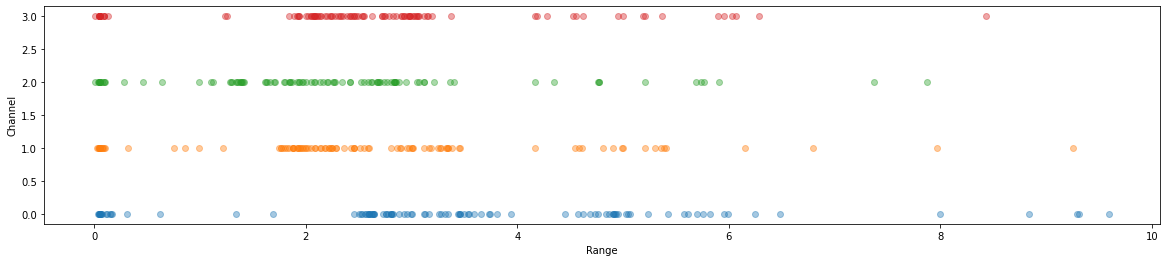

In [ ]:
plt.figure(figsize=(20,4))
for i in range(ranges.shape[1]):
    plt.plot(ranges[:, i], np.zeros_like(ranges[:, i]) + i, 'o', alpha=0.4)
plt.xlabel('Range')
plt.ylabel('Channel')

# Positions

## Direct Calc

In [ ]:
from scipy.optimize import minimize
def error(x, c, r):
    return np.sum((np.linalg.norm(x - c, axis=1) - r) ** 2)

# Initial guess is weighted average (by distance) of station coordinates
x0 = (h_locs[None, :, :] * 1.0 / ranges[:, :, None]).sum(axis=1) / (1.0 / ranges[:, :, None]).sum(axis=1)
     
# optimize distance from signal origin to border of spheres
locs = np.empty((ranges.shape[0], h_locs.shape[1]))
for i, (xx0, ran) in enumerate(zip(x0, ranges)):
    locs[i] = minimize(error, xx0, args=(h_locs[:, :], ran), method='Nelder-Mead').x


Text(0.5, 0.98, 'Direct Calc')

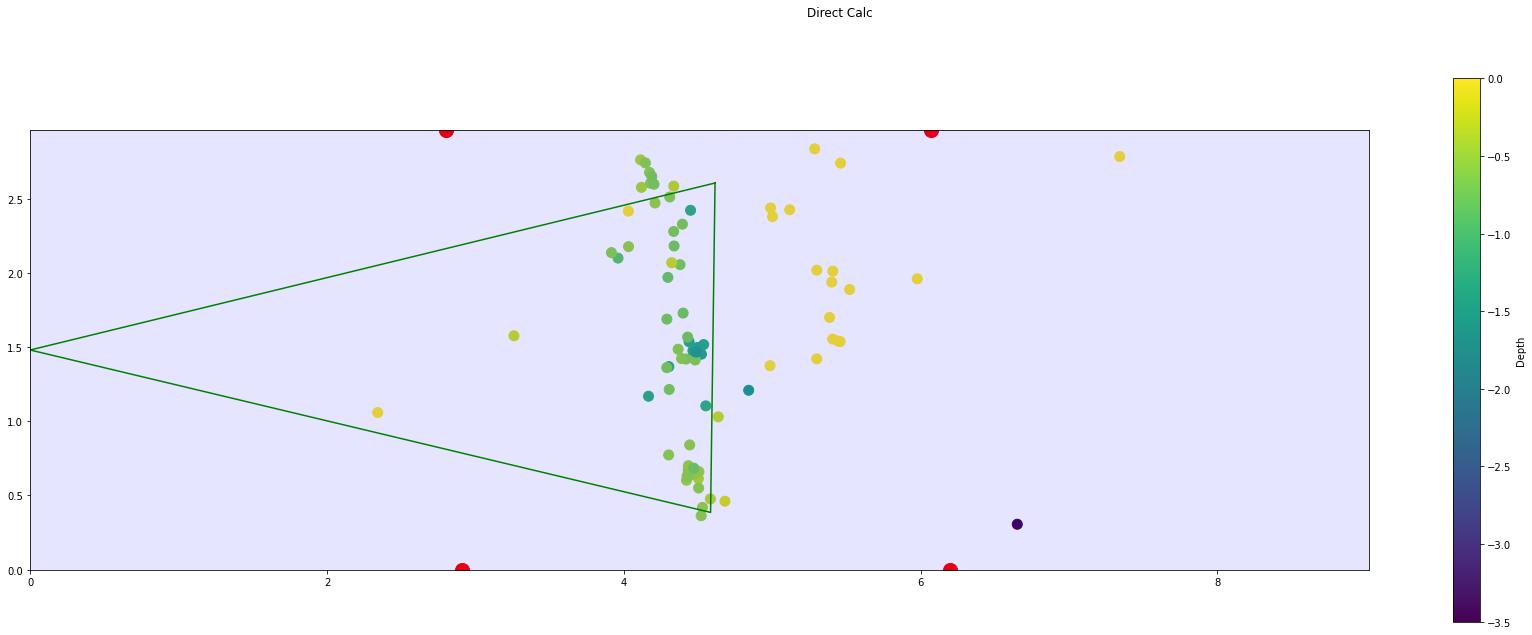

In [ ]:
f, ax = plt.subplots(1,1, figsize=(30,10))

draw_pool(ax, set_lim=True)
symbols = list("ov^<>sPD")
plt.scatter(locs[:, 0], locs[:, 1], c=locs[:, 2], s=100, vmin=D, vmax=0)
plt.colorbar(label='Depth')
f.suptitle("Direct Calc")

In [ ]:
valid = (locs[:, 0] > 0) & (locs[:, 0] < L) & (locs[:, 1] > 0) & (locs[:, 1] < W) & (locs[:, 2] < 0) & (locs[:, 2] > D)

In [ ]:
locs.shape, valid.shape

((102, 3), (102,))

Text(0.5, 0.98, '')

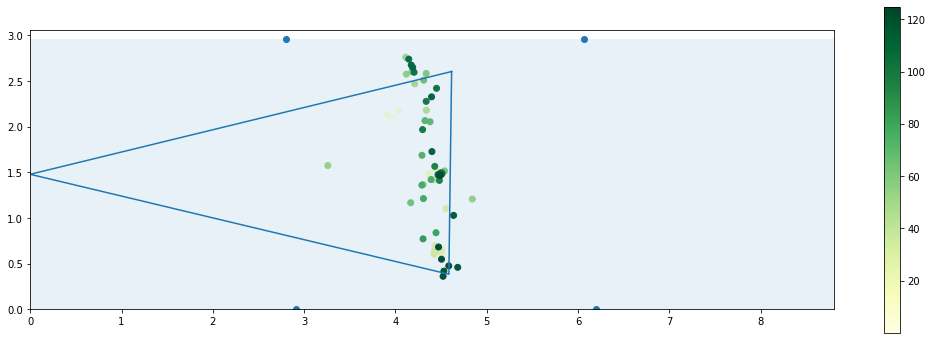

In [ ]:
f, ax = plt.subplots(1,1, figsize=(18,6))
# ax.axis('equal')
ax.set_aspect('equal', 'box')
ax.add_patch(mp_patches.Rectangle((0, 0), L, W, alpha=0.1))
ax.scatter(h_locs[:, 0], h_locs[:, 1])
ax.plot(*ground_truth.T, label="Ground Truth")

ax.set_xlim(0, 8.8)
ax.set_ylim(0, 3.06)

plt.scatter(*(locs[valid][:, :2].T), c=(indices[valid] * dt), cmap='YlGn')
plt.colorbar()
plt.suptitle('')

In [ ]:
position_data_zc = np.hstack(((indices[valid] * dt).reshape((-1, 1)), locs[valid]))
# np.savetxt('position_data_zc.csv', position_data_zc, delimiter=', ', header='t, x, y')

## With Fixed Depth

In [ ]:
depth = -0.4
from scipy.optimize import minimize
def error(x, c, r):
    return np.sum((np.linalg.norm(x - c, axis=1) - r) ** 2)

# Initial guess is weighted average (by distance) of station coordinates
x0 = (h_locs[None, :, :2] * 1.0 / ranges[:, :, None]).sum(axis=1) / (1.0 / ranges[:, :, None]).sum(axis=1)
     
# optimize distance from signal origin to border of spheres
locs = np.empty((ranges.shape[0], h_locs.shape[1]))
locs[:, 2] = depth
r = np.sqrt(ranges**2 - (h_locs[:, 2] - depth)**2)
for i, (xx0, ran) in enumerate(zip(x0, r)):
    locs[i, :2] = minimize(error, xx0, args=(h_locs[:, :2], ran), method='Nelder-Mead').x


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


Text(0.5, 0.98, 'Stationary')

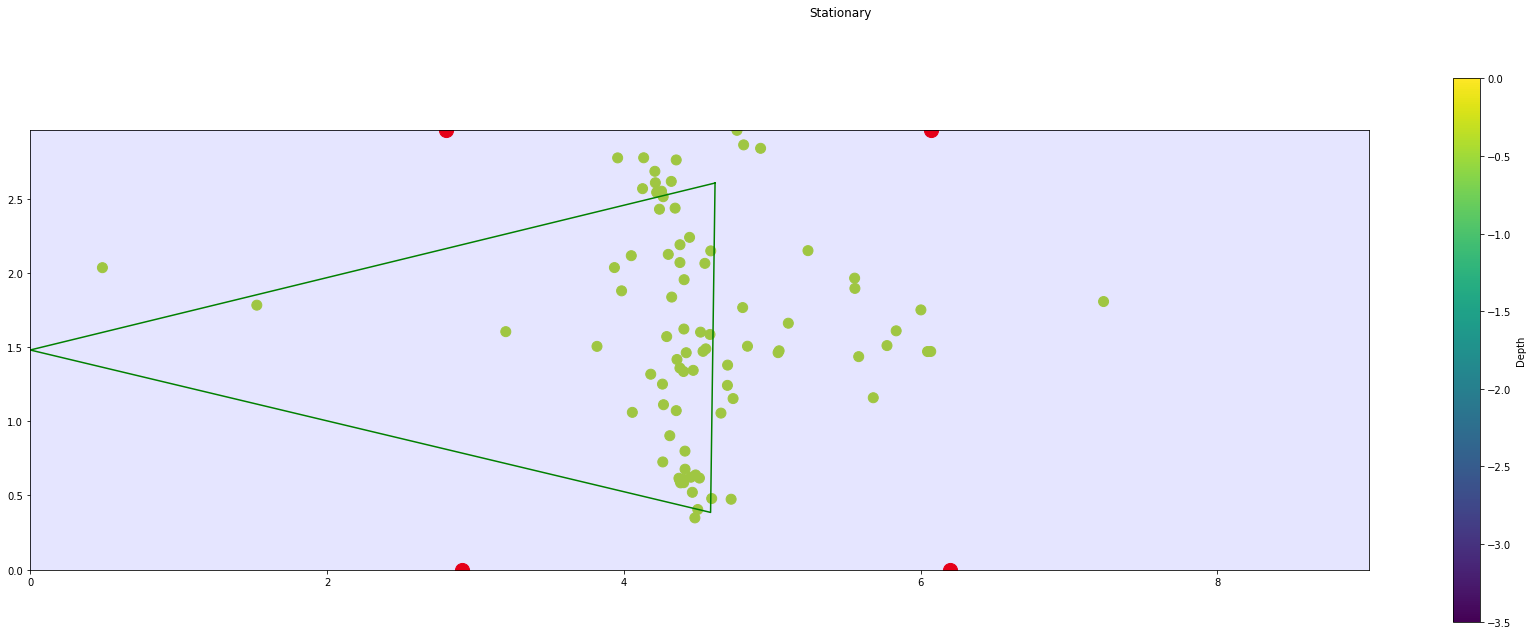

In [ ]:
f, ax = plt.subplots(1,1, figsize=(30,10))

draw_pool(ax, set_lim=True)
symbols = list("ov^<>sPD")
plt.scatter(locs[:, 0], locs[:, 1], c=locs[:, 2], s=100, vmin=D, vmax=0)
# plt.scatter(x0[:, 0], x0[:, 1], c=x0[:, 2], s=20, vmin=D, vmax=0)

plt.colorbar(label='Depth')

f.suptitle("Stationary")

# cs = [
#       ax.add_patch(mp_patches.Circle(loc[:2], 0, fill=False, alpha=0.2, linewidth=5))
#       for loc in h_locs
# ]

In [ ]:
valid = (locs[:, 0] > 0) & (locs[:, 0] < L) & (locs[:, 1] > 0) & (locs[:, 1] < W)
v_locs = locs[valid]

In [ ]:
locs.shape, v_locs.shape

((102, 3), (82, 3))

Text(0.5, 0.98, '')

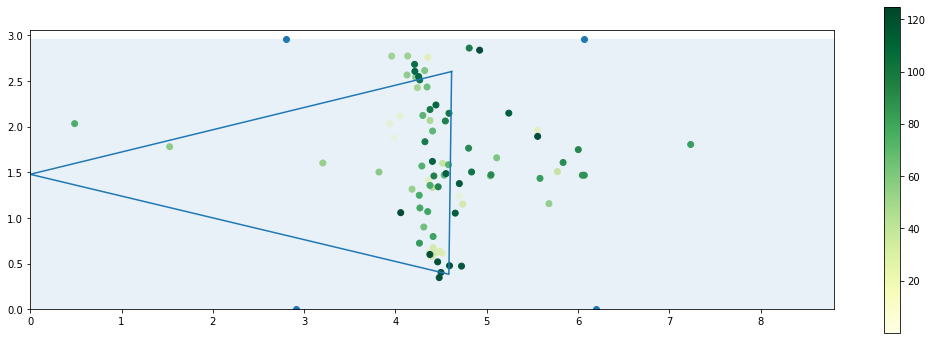

In [ ]:
f, ax = plt.subplots(1,1, figsize=(18,6))
# ax.axis('equal')
ax.set_aspect('equal', 'box')
ax.add_patch(mp_patches.Rectangle((0, 0), L, W, alpha=0.1))
ax.scatter(h_locs[:, 0], h_locs[:, 1])
ax.plot(*ground_truth.T, label="Ground Truth")

ax.set_xlim(0, 8.8)
ax.set_ylim(0, 3.06)

plt.scatter(*(v_locs[:, :2].T), c=(indices[valid] * dt), cmap='YlGn')
plt.colorbar()
plt.suptitle('')

## Voting

In [ ]:
from itertools import combinations, chain
from scipy.optimize import minimize
def error(x, c, r):
    return np.sum((np.linalg.norm(x - c, axis=1) - r) ** 2)

locs = np.empty((ranges.shape[0], h_locs.shape[1]))
for i, ran in enumerate(ranges):
    min_err = float('inf')
    
    best_loc = np.array([np.nan]*h_locs.shape[1])

    inds_list = combinations(np.where(np.isfinite(ran))[0], 3)
    inds_list = chain(inds_list, [(0,1,2,3),])

    for inds in inds_list:
        inds = list(inds)
        # Initial guess is weighted average (by distance) of station coordinates
        hl = h_locs[inds, :]
        ds = ran[inds]

        x0 = (hl[:, :] + ds[:, None]).sum(axis=0) / np.sum(ds)

        # optimize distance from signal origin to border of spheres
        loc = minimize(error, x0, args=(hl[:, :], ds), method='Nelder-Mead').x
        xxx, yyy, zzz = loc
        if (0 < xxx < L) and (0 < yyy < W) and (D < zzz < 0):    
            err = error(loc, hl[:, :], ds) / len(ds)
            if err < min_err:
                min_err = err
                best_loc = loc
    locs[i] = best_loc

In [ ]:
valid = ~np.isnan(locs).any(axis=1)
t, locs = indices[valid] * dt, locs[valid]

In [ ]:
locs.shape

(82, 3)

Text(0.5, 0.98, 'Stationary')

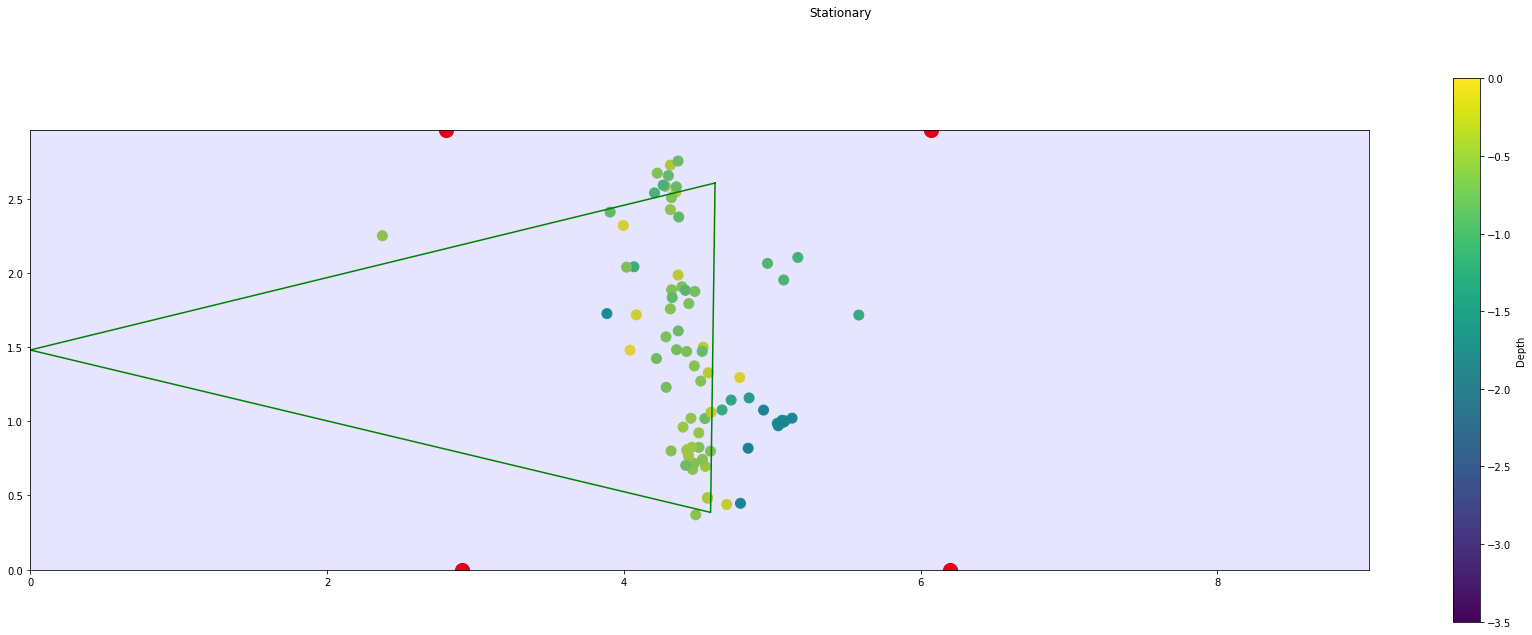

In [ ]:
f, ax = plt.subplots(1,1, figsize=(30,10))

draw_pool(ax, set_lim=True)
symbols = list("ov^<>sPD")
plt.scatter(locs[:, 0], locs[:, 1], c=locs[:, 2], s=100, vmin=D, vmax=0)
plt.colorbar(label='Depth')

f.suptitle("Stationary")

Text(0.5, 0.98, '')

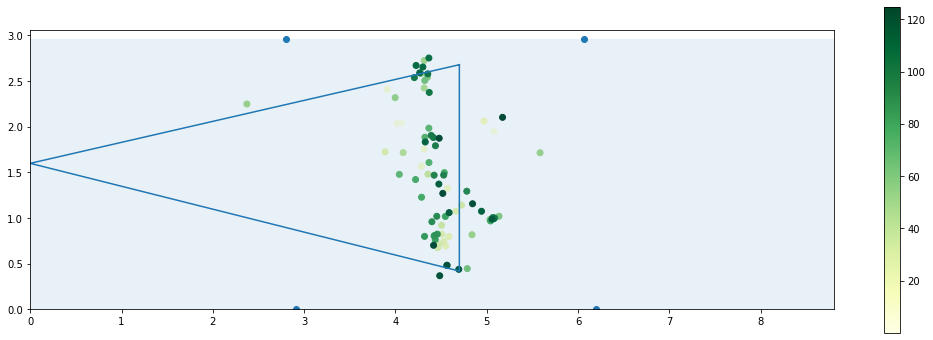

In [ ]:
f, ax = plt.subplots(1,1, figsize=(18,6))
# ax.axis('equal')
ax.set_aspect('equal', 'box')
ax.add_patch(mp_patches.Rectangle((0, 0), L, W, alpha=0.1))
ax.scatter(h_locs[:, 0], h_locs[:, 1])
ax.plot(*zip([4.7, 2.68], [0, 1.6], [4.7, 0.42], [4.7, 2.68]), label="Ground Truth")

ax.set_xlim(0, 8.8)
ax.set_ylim(0, 3.06)

plt.scatter(*(locs[:, :2].T), c=(t), cmap='YlGn')
plt.colorbar()
plt.suptitle('')

In [ ]:
position_data_zc_voting = np.hstack((t.reshape((-1, 1)), locs))
# np.savetxt('position_data_zc.csv', position_data_zc, delimiter=', ', header='t, x, y')

## Voting w/ Fixed Depth - BAD

In [ ]:
from itertools import combinations, chain
from scipy.optimize import minimize
def error(x, c, r):
    return np.sum((np.linalg.norm(x - c, axis=1) - r) ** 2)

depth = -0.5
locs = np.empty((ranges.shape[0], h_locs.shape[1]))
locs[:, 2] = depth
for i, ran in enumerate(ranges):
    min_err = float('inf')
    
    best_loc = np.array([np.nan]*2)

    inds_list = combinations(np.where(np.isfinite(ran))[0], 3)
    inds_list = chain(inds_list, [(0,1,2,3),])

    for inds in inds_list:
        inds = list(inds)
        # Initial guess is weighted average (by distance) of station coordinates
        hl = h_locs[inds, :2]
        ds = ran[inds]

        x0 = (hl[:, :2] + ds[:, None]).sum(axis=0) / np.sum(ds)

        # optimize distance from signal origin to border of spheres
        loc = minimize(error, x0, args=(hl[:, :2], ds), method='Nelder-Mead').x
        xxx, yyy = loc
        if (0 < xxx < L) and (0 < yyy < W):    
            err = error(loc, hl[:, :2], ds) / len(ds)
            if err < min_err:
                min_err = err
                best_loc = loc
    locs[i, :2] = best_loc

In [ ]:
valid = ~np.isnan(locs).any(axis=1)
t, locs = indices[valid] * dt, locs[valid]

In [ ]:
locs.shape

(90, 3)

Text(0.5, 0.98, 'Stationary')

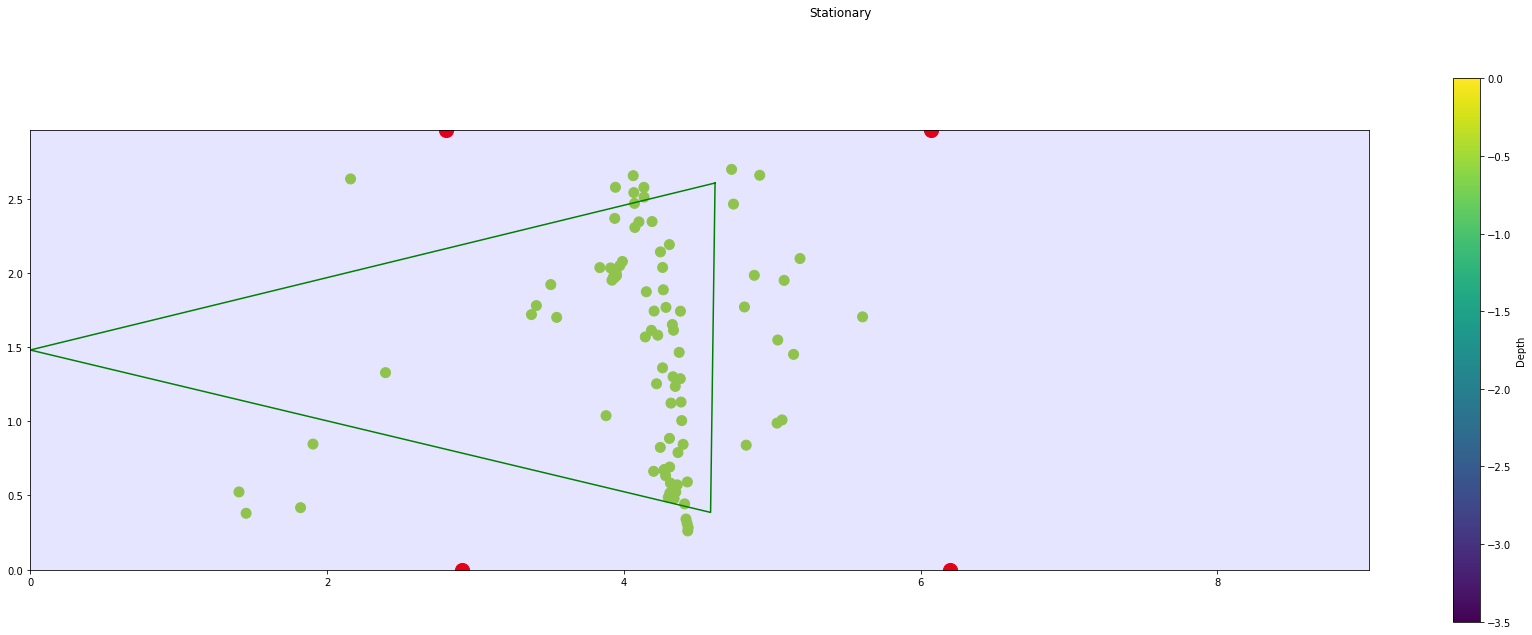

In [ ]:
f, ax = plt.subplots(1,1, figsize=(30,10))

draw_pool(ax, set_lim=True)
symbols = list("ov^<>sPD")
plt.scatter(locs[:, 0], locs[:, 1], c=locs[:, 2], s=100, vmin=D, vmax=0)
plt.colorbar(label='Depth')

f.suptitle("Stationary")

Text(0.5, 0.98, '')

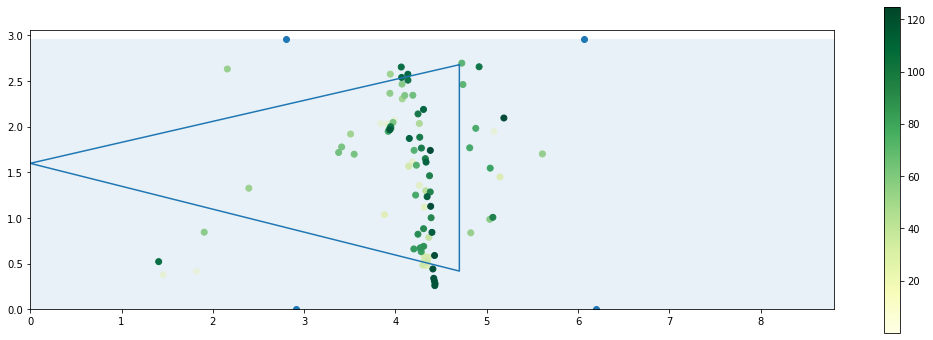

In [ ]:
f, ax = plt.subplots(1,1, figsize=(18,6))
# ax.axis('equal')
ax.set_aspect('equal', 'box')
ax.add_patch(mp_patches.Rectangle((0, 0), L, W, alpha=0.1))
ax.scatter(h_locs[:, 0], h_locs[:, 1])
ax.plot(*zip([4.7, 2.68], [0, 1.6], [4.7, 0.42], [4.7, 2.68]), label="Ground Truth")

ax.set_xlim(0, 8.8)
ax.set_ylim(0, 3.06)

plt.scatter(*(locs[:, :2].T), c=(t), cmap='YlGn')
plt.colorbar()
plt.suptitle('')

# Ranges

In [ ]:
h_loc = h_locs[2, :]
ran = ranges[:, 2]
t = indices * dt

In [ ]:
x_coord = ground_truth[0][0]

In [ ]:
y_coords = h_loc[1] - np.sqrt(ran**2 - (h_loc[0] - x_coord)**2 - (h_loc[2]- -0.5)**2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


In [ ]:
valid = (y_coords > 0) & (y_coords < W)
valid = (y_coords > ground_truth[-2][1]) & (y_coords < ground_truth[0][1])

In [ ]:
t, y_coords = t[valid], y_coords[valid]
ran.shape, y_coords.shape

((102,), (44,))

(array([16., 15., 29., 27.,  3.,  2.,  4.,  4.,  0.,  2.]),
 array([4.440000e-03, 7.912080e-01, 1.577976e+00, 2.364744e+00,
        3.151512e+00, 3.938280e+00, 4.725048e+00, 5.511816e+00,
        6.298584e+00, 7.085352e+00, 7.872120e+00]),
 <a list of 10 Patch objects>)

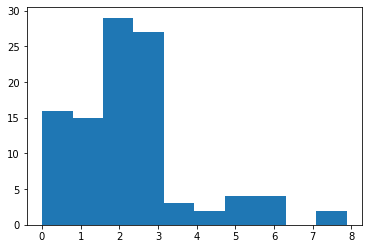

In [ ]:
plt.hist(ran)

(array([6., 4., 6., 1., 2., 5., 6., 8., 2., 4.]),
 array([1.9166  , 2.036184, 2.155768, 2.275352, 2.394936, 2.51452 ,
        2.634104, 2.753688, 2.873272, 2.992856, 3.11244 ]),
 <a list of 10 Patch objects>)

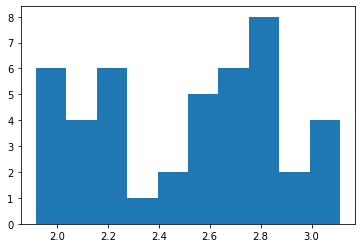

In [ ]:
plt.hist(ran[valid])

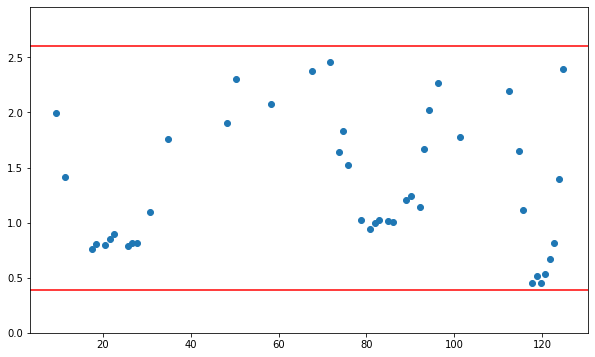

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(t, y_coords, 'o')
plt.ylim(0, W)
plt.axhline(ground_truth[0][1], color='red')
plt.axhline(ground_truth[-2][1], color='red')

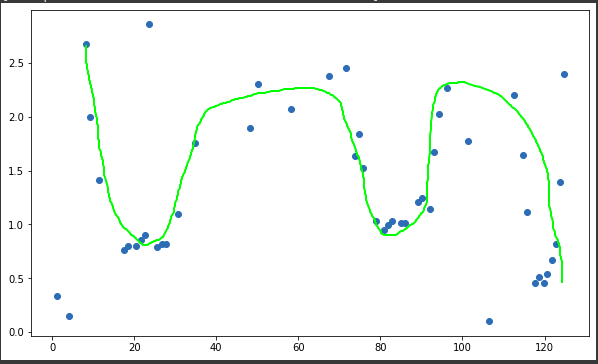